In [1]:
from matplotlib import pyplot as plt
import matplotlib 
import os
import numpy as np
import pickle
import pandas as pd
import copy
%matplotlib inline

rew_config = pd.read_pickle('./georgedata/rew_config.p')
model_config = pd.read_pickle('./georgedata/model_config.p')

# Model/rew info

Information on the model configuration and the REWs are in the two config files. These come in the form of Python dictionaries. ``rew_config`` is keyed on REW id's; each id number corresponds to the `cat` attribute in the stream/basin shapefiles in the ``georgedata`` folder (in case you feel like opening these up in QGIS or something). ``model_config`` contains all the config stuff for the current model run. For the purpose of introducing you to all of this stuff, I made it a very minimal set of model data; the watershed is just the south fork@branscomb, and the model run dates are only for a few years. FYI, in ``model_config``, there are three important dates. A ``start_date``, ``spinup_date``, and ``stop_date``. The start date defines when the model run begins, the spinup date defines when the model has "spun up" (i.e. when initial transients are considered "forgotten" for the purposes of calibration/validation) and a stop date when the model run stops. Forcing data is only extracted between the start and stop dates. 

In [10]:
print('Model run start date is ' + str(model_config['start_date']))

Model run start date is 2012-01-01


In [13]:
rew_id = 5
print('Contributing area of rew %s (not including upstream rew\'s) is %.2f square km'%(str(5), rew_config[5]['area_sqkm']))

Contributing area of rew 5 (not including upstream rew's) is 3.08 square km


# Connecting REWs to climatic forcing

To save time on model runs, I aggregate REWs to different climate "groups". These are areas where climate is averaged across a collection of REWs to save on having to run the model separately each REW in the group. The ``rew_config`` dictionary contains info for mapping an REW to its climate group. So, below, you see that ``rew_config[5]`` prints a dictionary entry (another dictionary) and one of the entries is ``climate_group``. In this case, the climate group is 1. So, to get the climate forcing for REW 5, I search the ``climate_group_forcing`` dictionary for key 1. The data stored there will be a pandas dataframe with the requisite climate forcing data (precip, PET, etc).

In [14]:
climate_group_forcing = pd.read_pickle('./georgedata/climate_group_forcing.p')
rew_id = 5
climate_group = rew_config[rew_id]['climate_group']
print('Climate group for REW %d is %s\n\nPreview of climate group %s dataframe:'%(rew_id, str(climate_group), str(climate_group)))
climate_group_forcing[climate_group].head()

Climate group for REW 5 is 1

Preview of climate group 1 dataframe:


,year,yday,dayl,ppt,srad,tmax,tmin,vp,es,p,tmean,pet
2012-01-01,2012.0,1.0,33177.601562,0.00,250.026666,17.633333,2.666667,736.000000,1441.091135,95180.367611,10.150000,0.142496
2012-01-02,2012.0,2.0,33246.721094,0.00,162.773333,12.700000,5.733333,920.000000,1441.091135,95180.367611,9.216667,0.094334
2012-01-03,2012.0,3.0,33523.199219,0.24,168.746668,12.800000,4.466667,837.333333,1441.091135,95180.367611,8.633333,0.101382
2012-01-04,2012.0,4.0,33523.199219,0.00,237.866668,16.000000,3.466667,792.000000,1441.091135,95180.367611,9.733333,0.130107
2012-01-05,2012.0,5.0,33523.199219,0.00,181.973334,12.166667,4.333333,826.666667,1441.091135,95180.367611,8.250000,0.097776


# Messing with the data

Things to note about the data. 

1. All the PET/precip/etc are in units of cm per day! I know. It's weird. I regret making that choice, but had reasons when first started. 
2. Not all the data is necessarily used in the model, but I threw it in here for you. For example, ``srad`` is solar radiation, and only comes into play when I do the temp modeling.
3. Ummm...i don't know what else. Just email if you have questions. 

Here's how to access the data:

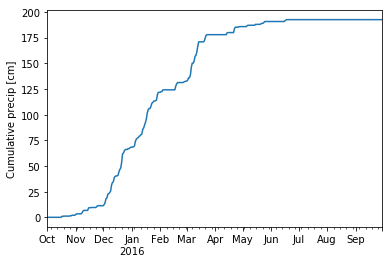

In [15]:
startdate = '2015-10-01'
enddate = '2016-09-30'
rew5ppt = climate_group_forcing[climate_group]['ppt'][startdate:enddate]
rew5ppt.cumsum().plot()
plt.ylabel('Cumulative precip [cm]')

# REW level forcing data

If you'd rather mess with REW level data (to be aggregated to climate groups later; perhaps groups that you yourself specify), I've also included the individual REW forcings. In the model prep scripts, these are the dataframes that I aggregate to create climate groups. You can see, the REW level forcings have the same format as the climate group forcings. So, depending on your question, you may want to alter the climate at the REW level, or at the climate group level. We can discuss this more and make decisions based off the science questions you're trying to answer. 


In [16]:
rew_forcings = pd.read_pickle('./georgedata/rew_forcing.p')
rew_forcings[5].head()

,year,yday,dayl,ppt,srad,tmax,tmin,vp,es,p,tmean,pet
2012-01-01,2012.0,1.0,33177.601562,0.0,265.600006,17.5,2.0,720.0,1418.410562,94016.642035,9.75,0.143159
2012-01-02,2012.0,2.0,33523.199219,0.0,166.399994,12.0,5.0,880.0,1418.410562,94016.642035,8.50,0.092206
2012-01-03,2012.0,3.0,33523.199219,0.3,144.000000,12.5,4.0,800.0,1418.410562,94016.642035,8.25,0.101071
2012-01-04,2012.0,4.0,33523.199219,0.0,249.600006,16.0,3.0,760.0,1418.410562,94016.642035,9.50,0.131591
2012-01-05,2012.0,5.0,33523.199219,0.0,188.800003,12.0,4.0,800.0,1418.410562,94016.642035,8.00,0.098031


# Altering the data and saving it

When you're ready to try out "future climate scenarios", you'll want to edit these forcing files and give them back to me to run the model for you. Here is an example of how to increase rainfall by 10% for each REW. 

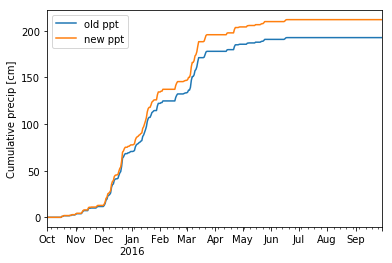

In [17]:
rew_ids = [item for item in rew_forcings.keys()]
rew_forcings_new = {}
for rew_id in rew_ids:
    tmp = rew_forcings[rew_id].copy()
    tmp.ppt = tmp.ppt + 0.10*tmp.ppt
    rew_forcings_new[rew_id] = tmp
    
# Plot to check
startdate = '2015-10-01'
enddate = '2016-09-30'
rew5ppt = rew_forcings[5]['ppt'][startdate:enddate]
rew5ppt_new = rew_forcings_new[5]['ppt'][startdate:enddate]
f,ax = plt.subplots(1)
rew5ppt.cumsum().plot(ax=ax, label='old ppt')
rew5ppt_new.cumsum().plot(ax=ax, label='new ppt')
ax.legend()
plt.ylabel('Cumulative precip [cm]')

# Save the new data
pickle.dump(rew_forcings_new, open('./georgedata/rew_forcings_new.p', 'wb') )